# 1. Prepare

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import sys
import os
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns

#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.models.data_generator import DataGenerator
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet, get_unet_mod
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

SHAPE = (512,768)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [3]:
import warnings
warnings.filterwarnings("ignore")

### Check if GPU available:

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Read Dataframes:

In [5]:
df = pd.read_pickle(DATA_BASE_PATH+"/df")
df.head(1)

image_path              mask_path  \
0  ../data/00_all/images/  ../data/00_all/masks/   

                mask_cirlce_path          name dataset  \
0  ../data/00_all/masks_autogen/  img_1000.png    None   

                                            mask_rle  \
0  773 253 1061 130 2308 255 2596 131 3845 254 41...   

                                     mask_circle_rle  \
0  210163 81 214744 135 219334 171 223927 201 228...   

                                       roots  \
0  [[947.6608444830582, 198.98217169159952]]   

                                             splines  
0  [[[650.1494324934839, 103.97898089758343], [72...

### Load Splited Data

In [6]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


In [7]:
train_df.sample(1)

image_path              mask_path  \
158  ../data/00_all/images/  ../data/00_all/masks/   

                  mask_cirlce_path          name dataset  \
158  ../data/00_all/masks_autogen/  img_1224.png    None   

                                              mask_rle  \
158  1868 27 1923 85 2015 35 2208 34 2264 41 3403 2...   

                                       mask_circle_rle  \
158  940 1491 5548 1491 10156 1491 14761 1497 19369...   

                                                 roots  \
158  [[1076.9054804517812, 471.1191272727273], [465...   

                                               splines  
158  [[[980.4395204170285, 546.3003176064442], [935...

# 3 Training:

### 3.1 Load UNet Model:

Vanilla UNet:

In [8]:
model = get_unet_mod(input_shape=(*SHAPE,3),feature_maps=[32,32,64,128,256,256,256,512],num_classes=2)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 768, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 768, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 768, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

Pretrained UNet:

In [18]:
from segmentation_models import Unet, PSPNet
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score
model = Unet("resnet50",input_shape=(512,768,3),encoder_weights="imagenet",freeze_encoder=True,classes=2)
#model.compile("Adam",loss=bce_jaccard_loss,metrics=[iou_score,dice_loss])

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 768, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 518, 774, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 384, 64) 9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

### 3.2 Define Train- Generator:

In [10]:
params = {'target_size': SHAPE,
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True}

# Generators
sample_gen = DataGenerator(df=train_df,hist_equal=True,augment_data=True,save_images=False,**params)
i_sample = iter(sample_gen)

Found 354 Files


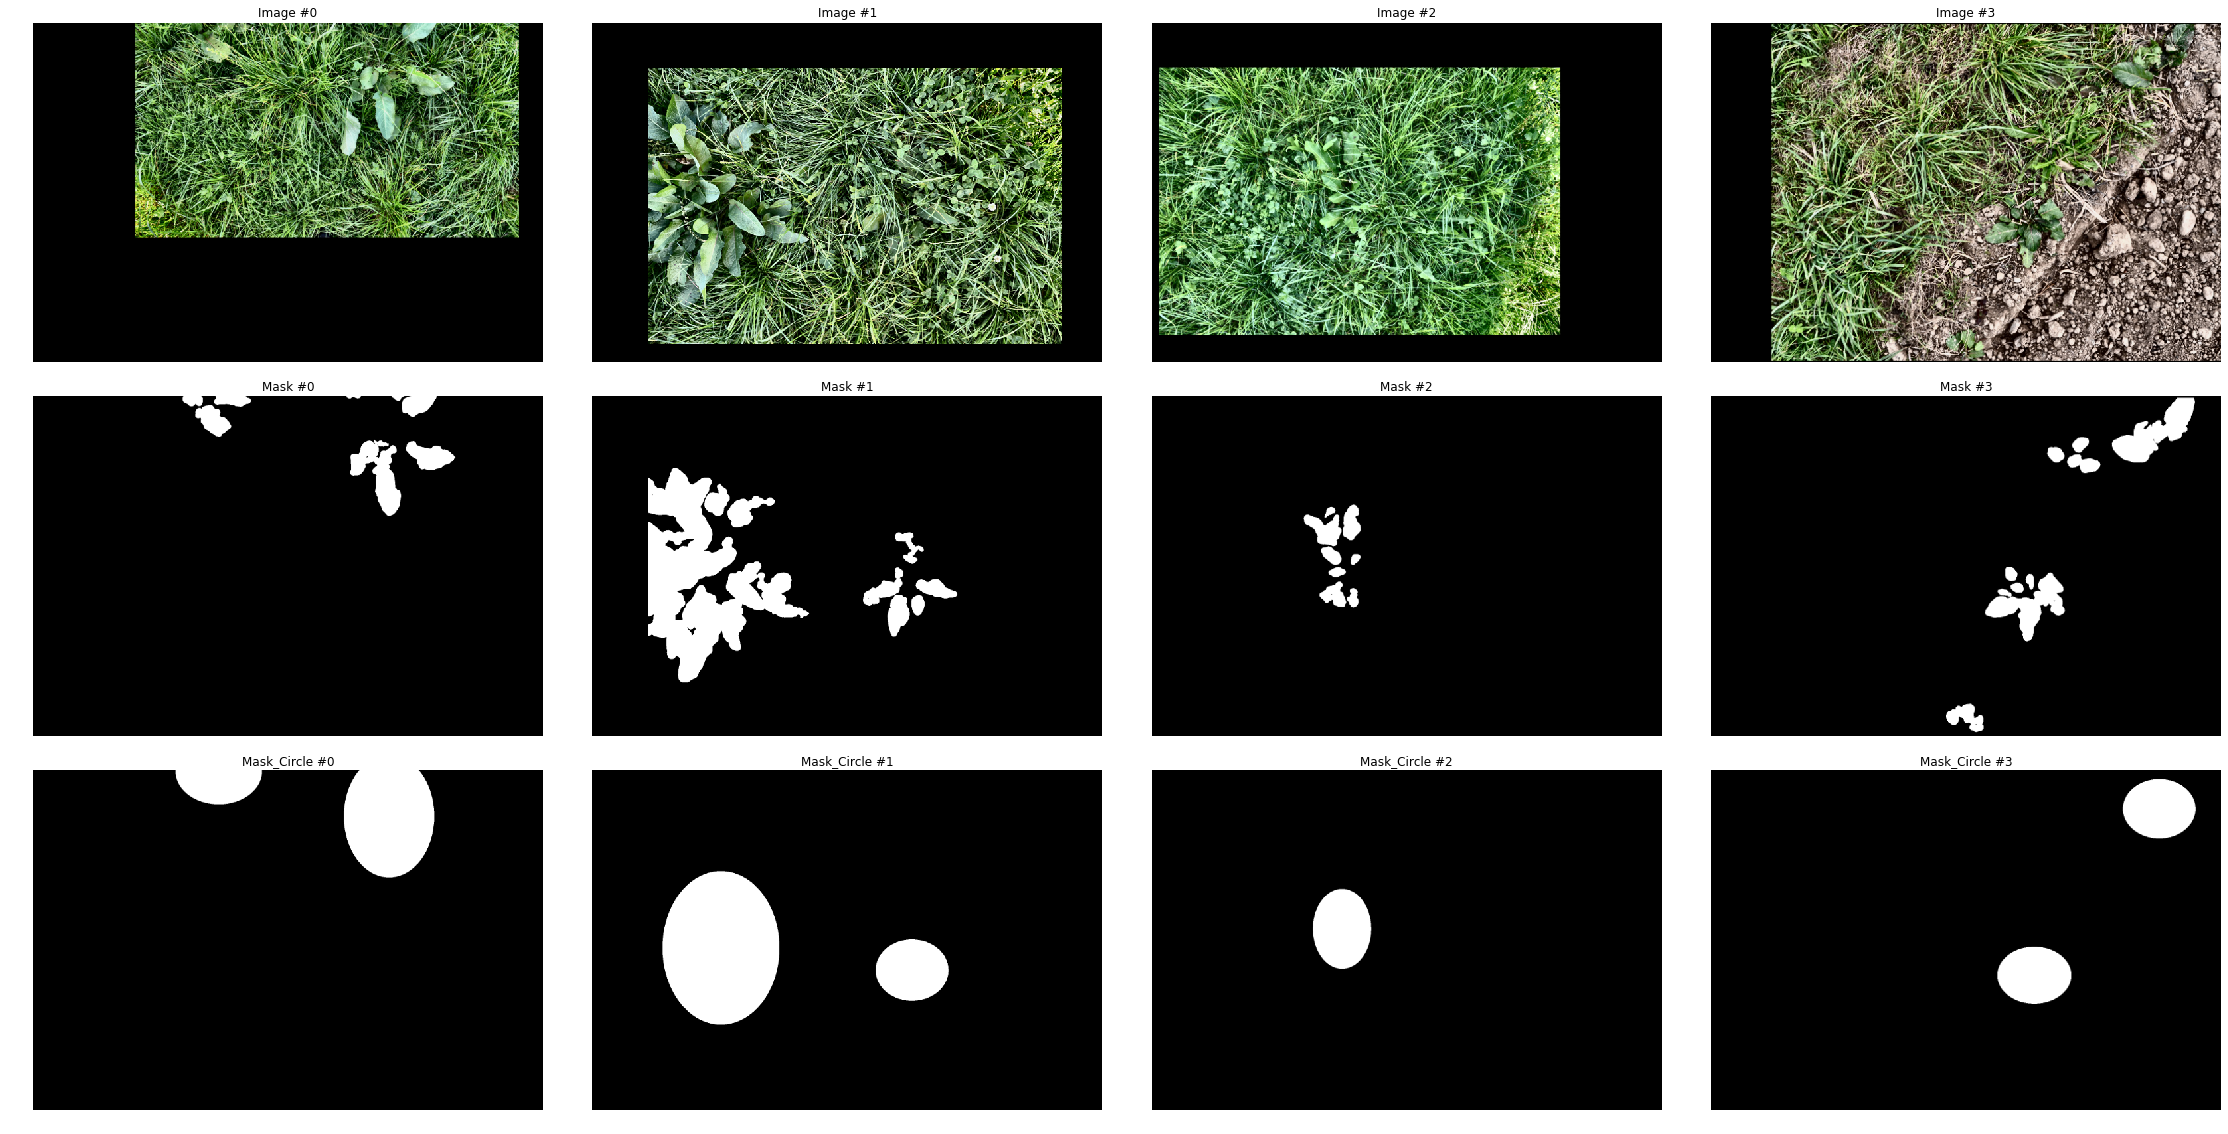

In [11]:
imgs,msks = next(i_sample)
plt.figure(figsize=(40,20))
x,y =4,1
for i in range(y):
    for j in range(x):
        plt.subplot(y*3,x,i*2*x+j+1)
        pos = i+j
        plt.imshow(imgs[pos,:,:,:].reshape(*SHAPE,3))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+1)*x+j+1)
        plt.imshow(msks[pos,:,:,0].reshape(SHAPE),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+2)*x+j+1)
        plt.imshow(msks[pos,:,:,1].reshape(SHAPE),cmap='gray')
        plt.title('Mask_Circle #{}'.format(pos))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()

In [12]:
print(imgs.shape)
print(msks.shape)
print(imgs.max())
print(msks.max())

(4, 512, 768, 3)
(4, 512, 768, 2)
1.0
1.0


### 3.5 Train:

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

BS = 4
import math
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.1
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    print("Learning Rate: " + str(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)


checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_dice_coeff', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coeff', 
                                   factor=0.1, 
                                   patience=6, 
                                   verbose=1, 
                                   mode='max', 
                                   epsilon=0.0001, 
                                   cooldown=6, 
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_dice_coeff", 
                      mode="max", 
                      patience=15,
                      restore_best_weights=True)

tensorboard = TensorBoard(log_dir='../docs/tensorboard', 
                            histogram_freq=0, 
                            batch_size=BS, 
                            write_graph=True, 
                            write_grads=False, 
                            write_images=False, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None, 
                            embeddings_data=None, 
                            update_freq='epoch')

callbacks_list = [early]

In [14]:
params = {'target_size': (512,768),
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(df=train_df,hist_equal=True,augment_data=True,save_images=False,**params)
validation_generator = DataGenerator(df=val_df,hist_equal=True,**params)

Found 354 Files
Found 102 Files


In [ ]:
from keras.optimizers import RMSprop
from imports.models.losses import bce_dice_loss, dice_loss, weighted_bce_dice_loss, weighted_dice_loss, dice_coeff, iou, iou_loss
model.compile(optimizer=RMSprop(lr=0.0001),loss=bce_jaccard_loss,metrics=[iou_score,dice_coeff])

In [15]:
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train_df)*2 // BS,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BS,
    epochs=40,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/40
177/177 [==============================] - 130s 736ms/step - loss: 1.1175 - dice_coeff: 0.2382 - iou: 0.6924 - val_loss: 12.8691 - val_dice_coeff: 0.1308 - val_iou: 0.3857
Epoch 2/40
177/177 [==============================] - 113s 637ms/step - loss: 0.6508 - dice_coeff: 0.4934 - iou: 0.8923 - val_loss: 0.7455 - val_dice_coeff: 0.5506 - val_iou: 0.9043
Epoch 3/40
177/177 [==============================] - 113s 641ms/step - loss: 0.4728 - dice_coeff: 0.6417 - iou: 0.9506 - val_loss: 0.4625 - val_dice_coeff: 0.6867 - val_iou: 0.9483
Epoch 4/40
177/177 [==============================] - 114s 642ms/step - loss: 0.4027 - dice_coeff: 0.6983 - iou: 0.9645 - val_loss: 0.4022 - val_dice_coeff: 0.7079 - val_iou: 0.9627
Epoch 5/40
177/177 [==============================] - 115s 651ms/step - loss: 0.3681 - dice_coeff: 0.7270 - iou: 0.9697 - val_loss: 0.4000 - val_dice_coeff: 0.7248 - val_iou: 0.9654
Epoch 6/40
177/177 [==============================] - 116s 658ms/step - loss: 0.3577 - di

In [18]:
from segmentation_models.utils import set_trainable
set_trainable(model)

In [19]:
H2 = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train_df)*1 // BS,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BS,
    epochs=20,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

Epoch 1/20
88/88 [==============================] - 89s 1s/step - loss: 1.0012 - iou_score: 0.1856 - dice_coeff: 0.3434 - val_loss: 1.0002 - val_iou_score: 0.1996 - val_dice_coeff: 0.3637
Epoch 2/20
88/88 [==============================] - 78s 889ms/step - loss: 0.8828 - iou_score: 0.2591 - dice_coeff: 0.4489 - val_loss: 0.9744 - val_iou_score: 0.2562 - val_dice_coeff: 0.4369
Epoch 3/20
88/88 [==============================] - 79s 894ms/step - loss: 0.7848 - iou_score: 0.3311 - dice_coeff: 0.5409 - val_loss: 0.9770 - val_iou_score: 0.1882 - val_dice_coeff: 0.3363
Epoch 4/20
88/88 [==============================] - 79s 894ms/step - loss: 0.7070 - iou_score: 0.3977 - dice_coeff: 0.6028 - val_loss: 0.6996 - val_iou_score: 0.4084 - val_dice_coeff: 0.6193
Epoch 5/20
88/88 [==============================] - 79s 895ms/step - loss: 0.6482 - iou_score: 0.4506 - dice_coeff: 0.6464 - val_loss: 0.6955 - val_iou_score: 0.4166 - val_dice_coeff: 0.6134
Epoch 6/20
88/88 [==============================

Process ForkPoolWorker-273:
Process ForkPoolWorker-283:
Process ForkPoolWorker-285:
Process ForkPoolWorker-284:
Process ForkPoolWorker-281:
Process ForkPoolWorker-279:
Traceback (most recent call last):
Process ForkPoolWorker-288:
Process ForkPoolWorker-276:
Process ForkPoolWorker-278:
Process ForkPoolWorker-287:
Process ForkPoolWorker-286:
Traceback (most recent call last):
Process ForkPoolWorker-280:
Traceback (most recent call last):
Process ForkPoolWorker-277:
Process ForkPoolWorker-282:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-274:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-275:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (m

  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "skimage/transform/_warps_cy.pyx", line 131, in skimage.transform._w

KeyboardInterrupt: 

In [17]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':1,
              'model':model}

visualize = Visualize(**vis_params)

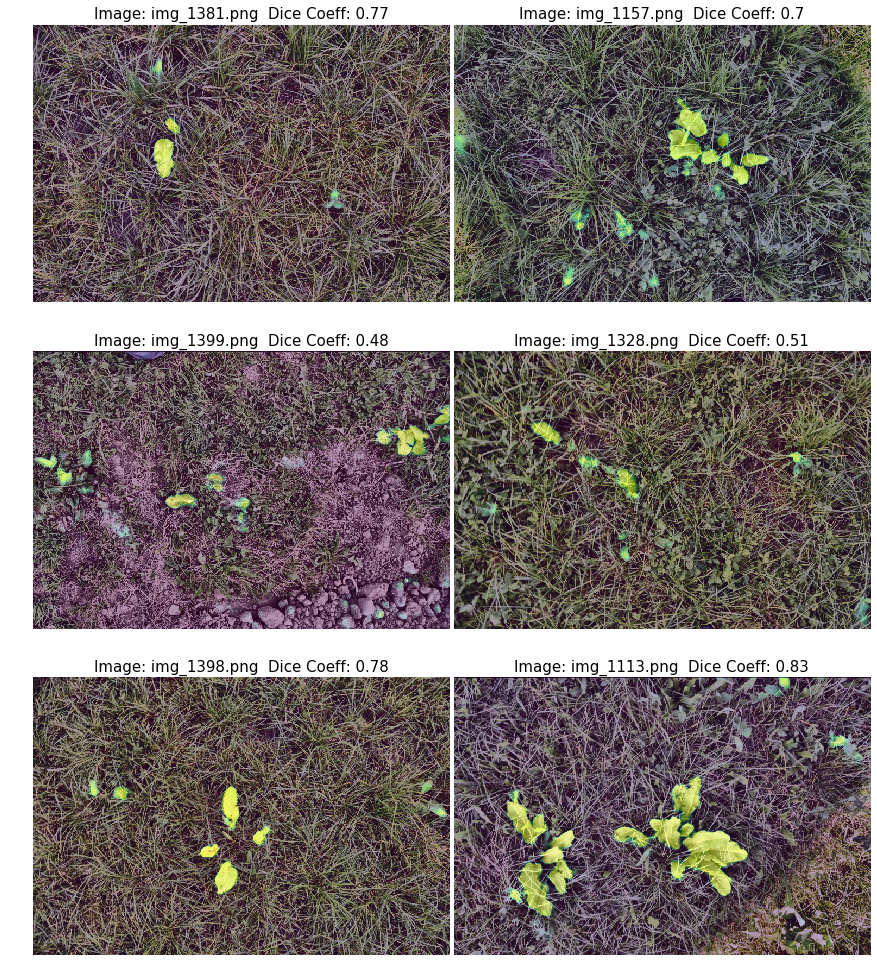

In [18]:
visualize.show_matrix(index='random',mode='image_prediction',rows=3)

In [19]:
H2 = H

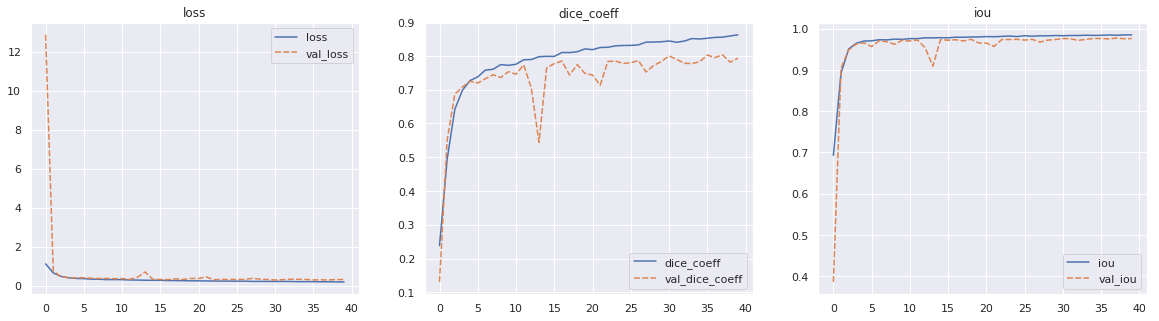

In [21]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "loss":H2.history['loss'],
        "val_loss":H2.history['val_loss']}
loss_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=loss_data).set_title("loss")

plt.subplot(1,3,2)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "dice_coeff":H2.history['dice_coeff'],
        "val_dice_coeff":H2.history['val_dice_coeff']}
dice_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=dice_data).set_title("dice_coeff")

plt.subplot(1,3,3)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "iou":H2.history['iou'],
        "val_iou":H2.history['val_iou']}
iou_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=iou_data).set_title("iou")

In [16]:
model.save('unet_dice_0.7930_iou_0.9759.h5')

In [22]:
loss_data.to_pickle("loss_data_df_unet_dice_0.7930_iou_0.9759")
dice_data.to_pickle("dice_data_df_unet_dice_0.7930_iou_0.9759")
iou_data.to_pickle("iou_data_df_unet_dice_0.7930_iou_0.9759")

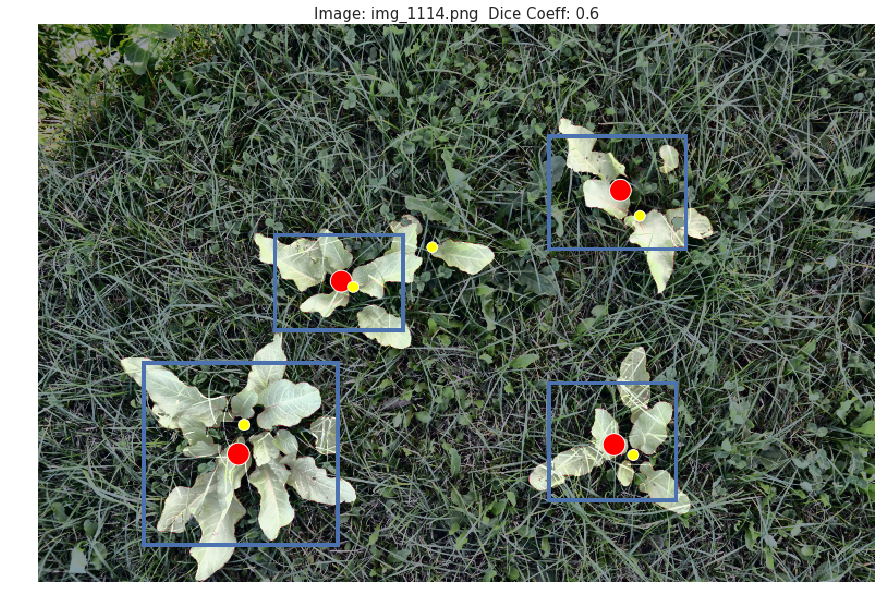

In [39]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

root_pred = Visualize(**vis_params)
#img_1114
root_pred.show_single("img_1114",mode="image_prediction_roots")

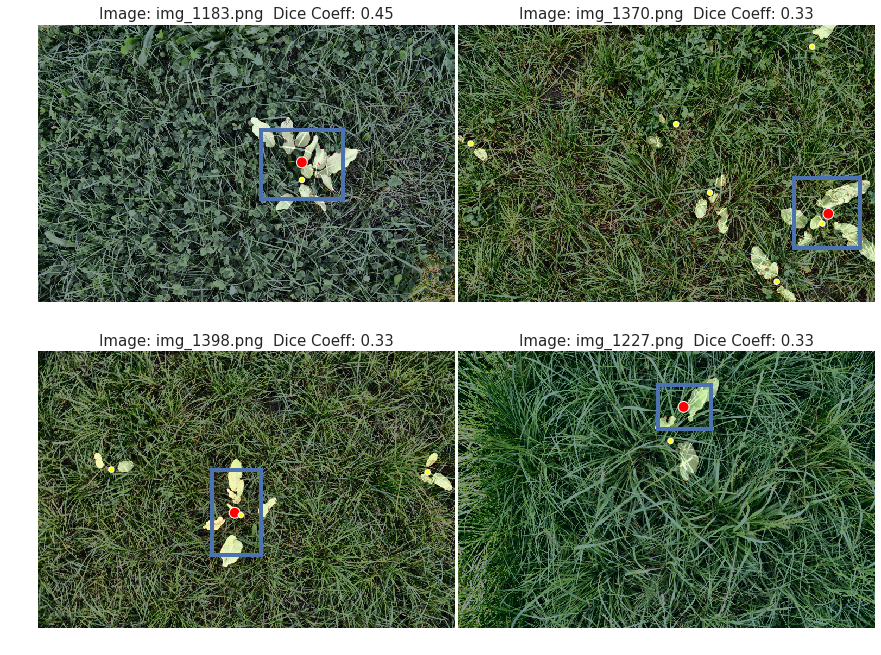

In [27]:
root_pred.show_matrix('random',mode="image_prediction_roots",rows=2)

### 3.7 Visualize Error Mask

In [44]:
ev_params = {'df':test_df,
             'input_shape':(512,768,3),
             'pred_layer' : 1,
             'model':model}
ev = Evaluate(**ev_params)

Aufsummiern aller falsch detektieren Masken (False Positive + False Negative):

In [48]:
def predict_all_error(df):
    error_sum = np.zeros(SHAPE)
    for i, row in df.iterrows():
        err = ev.get_full_error_mask(index=row['name'])
        error_sum += err
    return error_sum

In [49]:
summed_mask_error = predict_all_error(test_df)

Visualisierung aller überlagerten False Positiv + False Negativ Masken:

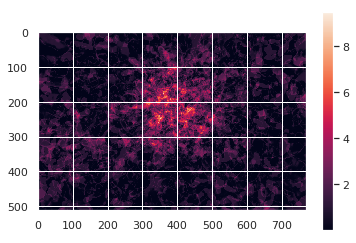

In [50]:
imshow(summed_mask_error)
plt.colorbar()

In [56]:
summed_mask_train = np.zeros((1024,1536))
for i,row in test_df.iterrows():
    summed_mask_train += rle_decode(row['mask_rle'],(1024,1536))
summed_mask_train = resize(summed_mask_train,(512,768))

Vergleich der summierten Trainingsmasken (Bild rechts) mit den summierten Falschen vorhersagen (Bild mitte). Das Bild rechts zeigt die subtraktion der normalisierten Trainingsmasken mit den normalisierten False Positiv + False Negativ:

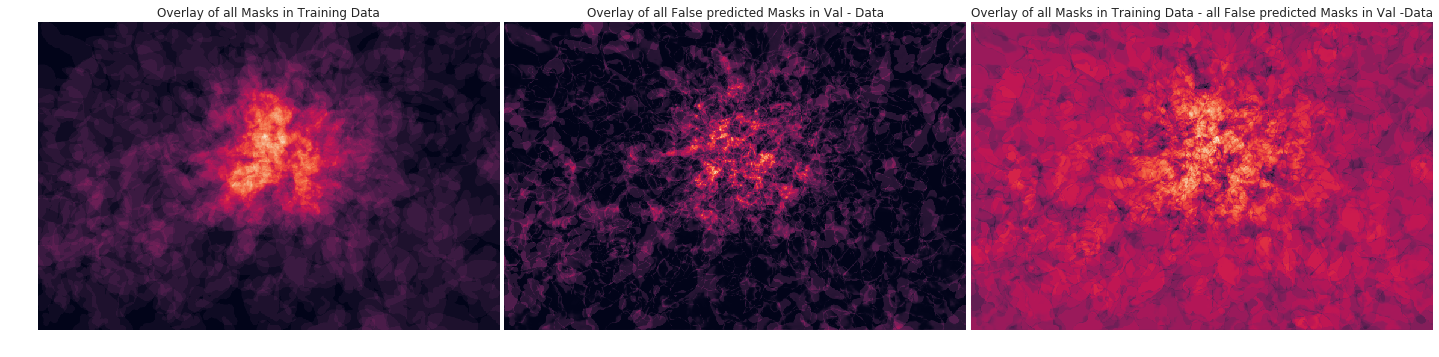

In [57]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(25,18))
axs[0].imshow(summed_mask_train)
axs[1].imshow(summed_mask_error)
#axs[1,0].imshow(summed_mask_train-summed_mask_error)
axs[2].imshow(summed_mask_train/summed_mask_train.max()-summed_mask_error/summed_mask_error.max())
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all False predicted Masks in Val - Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Training Data - all False predicted Masks in Val -Data')
axs[2].axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0)

Die meisten falsch vohergesagten Masken befinden sich zwar im Zentrum der Bilder (wie die meisten Masken in den Trainingsbildern), jedoch sind diese besser Verteilt als die Ground Truth Masken. (Die Farbskalierung der Bilder ist bei beiden gleich) 
Daraus schliesse ich, das sich die Anhäufung der GroundTruth- Masken in den Trainingsdaten im Zentrum, negativ auf die vorhersagen von Blacken im Randbereich asuwirkt. d.h. es werden im Randbereich der Bilder überdurchschnittlich viele Blacken falsch vorhergesagt.

<img src="../docs/notebook_images/False_negativ_positv.png">